In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from itertools import cycle

In [11]:
# 1. Load data
def load_data(file_path):
    # Membaca file CSV dengan format yang sesuai
    df = pd.read_csv(file_path)
    
    # Ekstrak fitur dan label
    X = df.iloc[:, :-2]  # Semua kolom kecuali kolom terakhir (label)
    y = df.iloc[:, -1]   # Kolom terakhir adalah label
    
    return X, y

# 2. Split data menjadi training dan testing
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

In [12]:
def plot_feature_distributions(X, y, num_features=5):
    # Gabungkan fitur dan label
    data = X.copy()
    data['label'] = y
    
    # Pilih beberapa fitur untuk visualisasi
    selected_features = X.columns[:num_features]
    
    # Plot distribusi fitur berdasarkan kelas
    plt.figure(figsize=(15, 10))
    for i, feature in enumerate(selected_features):
        plt.subplot(2, 3, i+1)
        for label in data['label'].unique():
            sns.kdeplot(data[data['label'] == label][feature], label=label)
        plt.title(f'Distribusi {feature}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

Loading data...
Data shape: (2053, 100)

Distribusi label original:
label
positif    955
negatif    661
netral     437
Name: count, dtype: int64
Rasio label: 2.19:1

Menampilkan distribusi fitur berdasarkan kelas...


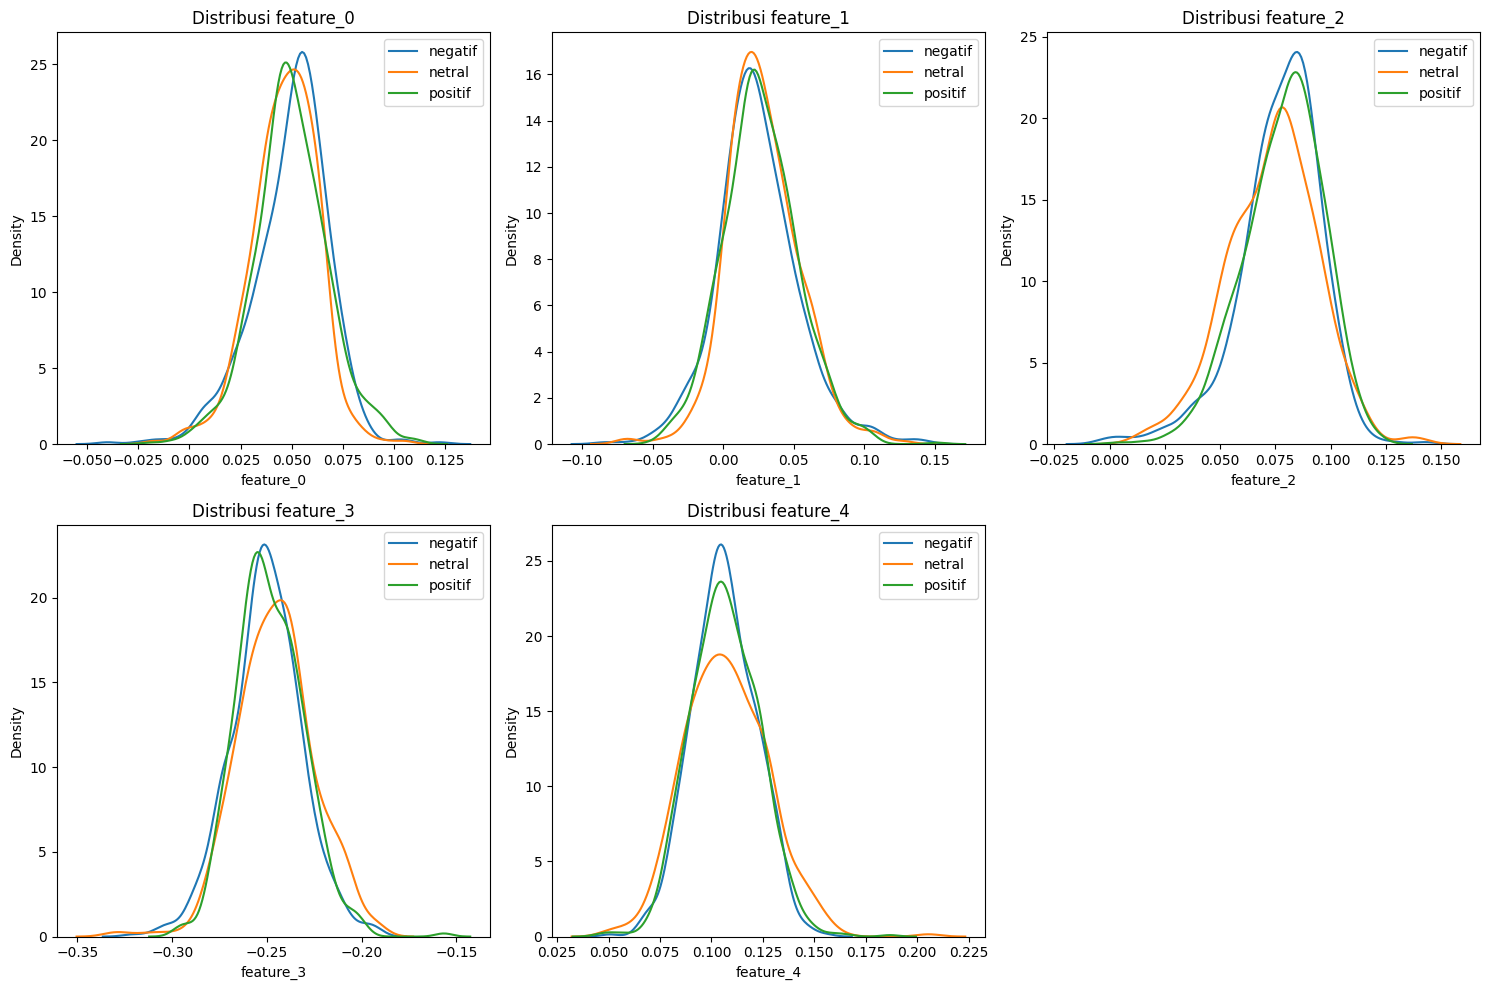


Splitting data...


In [13]:
# Load data
file_path = "./preprocess_data/word2vec_vectors(withlabel).csv"
print("Loading data...")
X, y = load_data(file_path)
print(f"Data shape: {X.shape}")
    
# Informasi kelas
print("\nDistribusi label original:")
class_counts = y.value_counts()
print(class_counts)
print(f"Rasio label: {class_counts.values[0] / class_counts.values[-1]:.2f}:1")
    
# Visualisasi distribusi fitur (opsional)
print("\nMenampilkan distribusi fitur berdasarkan kelas...")
plot_feature_distributions(X, y)    
# Split data
print("\nSplitting data...")
X_train, X_test, y_train, y_test = split_data(X, y)

In [14]:
def evaluate_model(model, X_test, y_test):
    # Prediksi pada data test
    y_pred = model.predict(X_test)
    
    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi pada data test: {accuracy:.4f}")
    
    # Tampilkan classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(y_test.unique()), 
                yticklabels=sorted(y_test.unique()))
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.title('Confusion Matrix - Naive Bayes dengan SMOTE')
    plt.show()
    
    # Prediksi probabilitas
    y_proba = model.predict_proba(X_test)
    
    # Hitung ROC AUC Score - multiclass
    # 'macro': Calculate metrics for each label, and find their unweighted mean (accounts for label imbalance)
    # 'weighted': Calculate metrics for each label, and find their average weighted by support (accounts for label imbalance)
    # 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives
    roc_auc_macro = roc_auc_score(y_test, y_proba, multi_class='ovr', average='macro')
    roc_auc_weighted = roc_auc_score(y_test, y_proba, multi_class='ovr', average='weighted')
    
    print("\nROC AUC Scores:")
    print(f"Macro-average ROC AUC: {roc_auc_macro:.4f}")
    print(f"Weighted-average ROC AUC: {roc_auc_weighted:.4f}")
    
    # Plot ROC Curve
    plot_roc_curve(model, X_test, y_test)
    
    return accuracy, y_pred

# Tambahan fungsi untuk ROC Curve dan AUC
def plot_roc_curve(model, X_test, y_test):
    # Dapatkan label unik
    classes = sorted(y_test.unique())
    n_classes = len(classes)
    
    # Binarize y_test (one-hot encoding)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Prediksi probabilitas
    y_score = model.predict_proba(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), np.concatenate([y_score[:, i] for i in range(n_classes)]).ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(figsize=(12, 8))
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
             color='navy', linestyle=':', linewidth=4)
    
    # Assign sentiment labels to class indices (assuming indices match sentiments)
    sentiment_labels = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
    if len(classes) == 3:
        # Map class indices to their actual sentiment labels if necessary
        class_to_sentiment = {classes[i]: sentiment_labels[i] for i in range(n_classes)}
    else:
        # Use the actual class values if they don't match our assumption
        class_to_sentiment = {c: str(c) for c in classes}
    
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {class_to_sentiment[classes[i]]} (area = {roc_auc[i]:.2f})')
    
    # Print AUC values for each class
    print("\nROC AUC values:")
    for i in range(n_classes):
        print(f"Class {class_to_sentiment[classes[i]]}: {roc_auc[i]:.4f}")
    print(f"Micro-average: {roc_auc['micro']:.4f}")
    print(f"Macro-average: {roc_auc['macro']:.4f}")
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC untuk klasifikasi multi-kelas (One-vs-Rest)')
    plt.legend(loc="lower right")
    plt.show()
    
    # Return overall AUC (macro-average)
    return roc_auc["macro"]

# 5. Visualisasi distribusi label sebelum dan sesudah SMOTE
def plot_class_distribution(y_train, y_resampled):
    plt.figure(figsize=(12, 5))
    
    # Distribusi sebelum SMOTE
    plt.subplot(1, 2, 1)
    sns.countplot(x=y_train)
    plt.title('Distribusi Kelas Sebelum SMOTE')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    
    # Distribusi setelah SMOTE
    plt.subplot(1, 2, 2)
    sns.countplot(x=y_resampled)
    plt.title('Distribusi Kelas Setelah SMOTE')
    plt.xlabel('Label')
    plt.ylabel('Jumlah')
    
    plt.tight_layout()
    plt.show()

# 6. Prediksi sentimen untuk data baru
def predict_sentiment(model, new_data):
    # Prediksi label
    prediction = model.predict(new_data)
    
    # Prediksi probabilitas
    probabilities = model.predict_proba(new_data)
    
    return prediction, probabilities

In [15]:
# 3. Train model Naive Bayes dengan SMOTE dan hyperparameter tuning
def train_nb_model_with_smote(X_train, y_train):
    # Pipeline dengan SMOTE, scaling, dan Naive Bayes
    smote_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('nb', GaussianNB())
    ])
    
    # Parameter grid untuk grid search
    param_grid = {
        'smote__k_neighbors': [5, 10, 15],  # Jumlah tetangga untuk SMOTE
        'nb__var_smoothing': np.logspace(-9, -1, 5)  # Hyperparameter var_smoothing
    }
    
    # Grid search untuk menemukan parameter terbaik
    grid_search = GridSearchCV(
        smote_pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=1, n_jobs=-1
    )
    
    # Fit model
    grid_search.fit(X_train, y_train)
    
    # Tampilkan parameter terbaik
    print("Parameter terbaik: ", grid_search.best_params_)
    print(f"Balanced accuracy terbaik dari cross-validation: {grid_search.best_score_:.4f}")
    
    # Return model dengan parameter terbaik
    return grid_search.best_estimator_


Distribusi setelah SMOTE:
label
positif    764
netral     764
negatif    764
Name: count, dtype: int64
Rasio label setelah SMOTE: 1.00:1


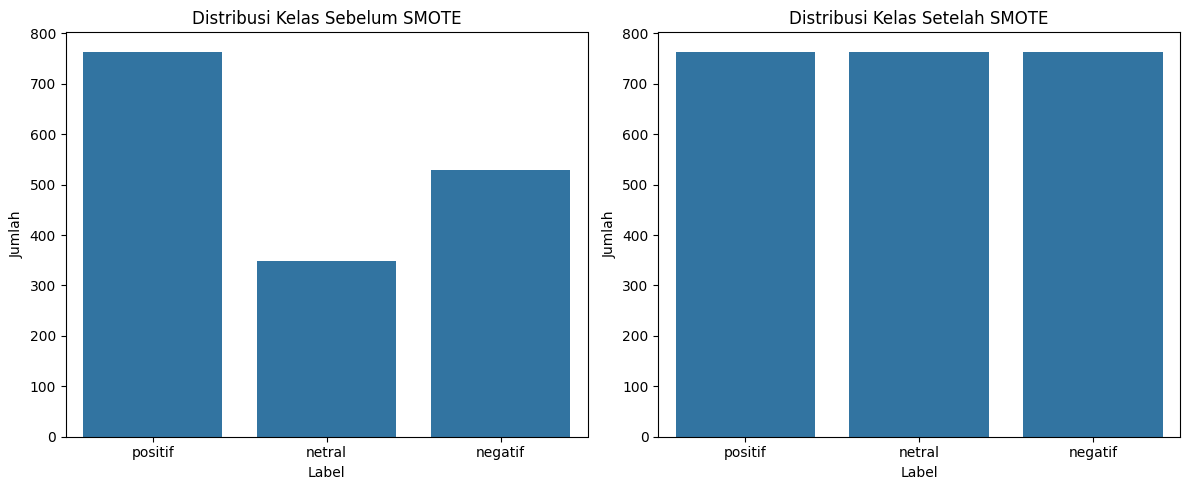

In [16]:
# Terapkan SMOTE hanya untuk demo visualisasi
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print("\nDistribusi setelah SMOTE:")
resampled_counts = pd.Series(y_resampled).value_counts()
print(resampled_counts)
print(f"Rasio label setelah SMOTE: {resampled_counts.values[0] / resampled_counts.values[-1]:.2f}:1")
    
# Visualisasi distribusi sebelum dan sesudah SMOTE
plot_class_distribution(y_train, y_resampled)

In [17]:
# Train model
print("\nTraining Naive Bayes model dengan SMOTE dan Grid Search...")
model = train_nb_model_with_smote(X_train, y_train)


Training Naive Bayes model dengan SMOTE dan Grid Search...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/home/whoami/.local/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Parameter terbaik:  {'nb__var_smoothing': 0.1, 'smote__k_neighbors': 15}
Balanced accuracy terbaik dari cross-validation: 0.4551



Evaluasi model pada data test:
Akurasi pada data test: 0.4745

Classification Report:
              precision    recall  f1-score   support

     negatif       0.42      0.63      0.50       132
      netral       0.45      0.33      0.38        88
     positif       0.56      0.43      0.49       191

    accuracy                           0.47       411
   macro avg       0.48      0.46      0.46       411
weighted avg       0.49      0.47      0.47       411



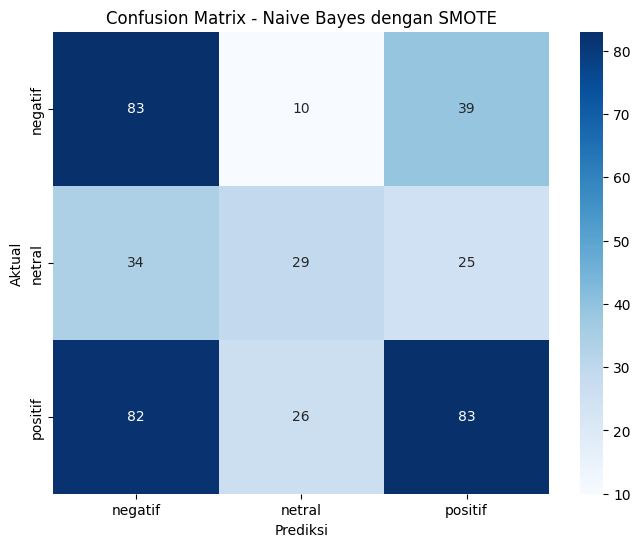


ROC AUC Scores:
Macro-average ROC AUC: 0.6351
Weighted-average ROC AUC: 0.6270

ROC AUC values:
Class Negative: 0.6492
Class Neutral: 0.6593
Class Positive: 0.5968
Micro-average: 0.5016
Macro-average: 0.6368


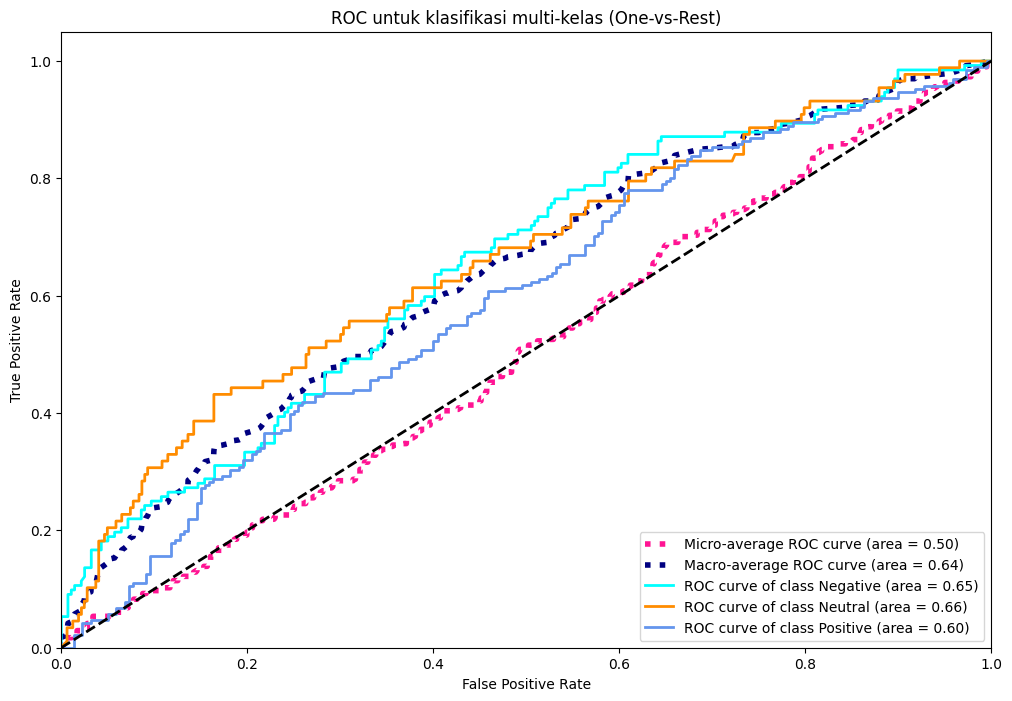

(0.4744525547445255,
 array(['negatif', 'netral', 'netral', 'netral', 'negatif', 'negatif',
        'positif', 'negatif', 'netral', 'netral', 'negatif', 'negatif',
        'netral', 'negatif', 'positif', 'positif', 'negatif', 'negatif',
        'positif', 'negatif', 'positif', 'negatif', 'negatif', 'negatif',
        'negatif', 'positif', 'positif', 'negatif', 'negatif', 'negatif',
        'negatif', 'negatif', 'positif', 'positif', 'positif', 'positif',
        'negatif', 'negatif', 'netral', 'negatif', 'positif', 'positif',
        'positif', 'negatif', 'negatif', 'positif', 'negatif', 'negatif',
        'negatif', 'positif', 'positif', 'positif', 'negatif', 'negatif',
        'netral', 'positif', 'positif', 'positif', 'negatif', 'positif',
        'negatif', 'negatif', 'negatif', 'negatif', 'positif', 'negatif',
        'positif', 'negatif', 'negatif', 'positif', 'negatif', 'negatif',
        'positif', 'negatif', 'positif', 'netral', 'negatif', 'positif',
        'negatif', 'negati

In [18]:
# Evaluasi model
print("\nEvaluasi model pada data test:")
evaluate_model(model, X_test, y_test)